## Predicting Returns of the loans:

As mentioned in other sections, some borrowers do not return loan within the term. It is therefore helpful to make a prediction of how much principal amount will be returned from a particular borrower. This will help in determining whether or not to give a loan to the particular borrower. Also, a proper calculation of the amount will help the company's next years income/loss. The goal of this section is to make a model predicting how much principal a particular lender return after the completion of the loan term. 

We perform a polynomial Regression method in scikit-learn to make these predictions. 

In [1]:
"""Import libraries"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [2]:
"""Read data in pandas"""

df = pd.read_csv('Intermediate_data\Trimmed.csv', 
                 parse_dates = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 
                                'next_pymnt_d', 'last_credit_pull_d'])

df['history'] = (df.issue_d - df.earliest_cr_line).dt.days 

df.drop(['Unnamed: 0'], axis = 1, inplace =  True)

In [3]:
"""For the purpose of this model, I consider only the loans 
that have completed the terms. """

df['termd'] = pd.to_timedelta(df.term, unit= 'M')

df_complete = df[df.issue_d + df.termd <df.issue_d.max()]

"""For the polynomial regression, the data analysis consumes a lot 
of physical memory. It will be beneficial to eliminate some unnessary
columns as well as the columns that has little significance to the data."""

remove_list = ['last_pymnt_amnt', 'collection_recovery_fee',
                  'recoveries', 'out_prncp_inv', 'out_prncp',
                  'int_rate', 'total_pymnt', 'total_pymnt_inv',
                  'total_rec_late_fee', 'total_rec_int',
                  'emp_title', 'debt_settlement_flag', 
                  'addr_state', 'purpose', 'delinq_amnt',
                  'hardship_flag', 'pymnt_plan', 
                  'earliest_cr_line', 'issue_d', 'last_pymnt_d',
                  'next_pymnt_d', 'termd']

feat_imp = pd.read_csv('G:\Capstone2\Intermediate_data\Feature_imp_GB.csv', sep=',')
remove_list2 = list(feat_imp[feat_imp.Feat_imp < 0.015]['Unnamed: 0'])

remove_list = remove_list + remove_list2

"""We will delete the columns one by one so that if some columns do
not exist there would be no error."""

for member in remove_list:
    try:
        df_complete.drop(member, axis = 1, inplace = True)
    except: continue

G:\Anaconda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [4]:
"""Converting categorical variables to numerical dummies. """

cate_list = list(df_complete.dtypes[df_complete.dtypes == 'object'].index)

df_cate = df[cate_list]

df_cat_dum = pd.get_dummies(df_cate, drop_first = True)

In [5]:
"""Replacing the missing values with their mean."""

df_num_col = df_complete.dtypes[df_complete.dtypes == 'float64']

df_num = df[list(df_num_col.index)]

for col in df_num.columns:
    df_num[col].fillna(df_num[col].mean(), inplace = True)

df_combined = pd.concat([df_num, df_cat_dum], axis = 1)

y = df_combined['total_rec_prncp']
X = df_combined.drop(['total_rec_prncp'], axis = 1).values

"""Data normalization """
scaled = StandardScaler().fit_transform(X)

"""Train test split"""
X_train, X_test, y_train, y_test = train_test_split(scaled,
                                                    y, test_size=0.5,
                                                    random_state=77)

G:\Anaconda\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [6]:
"""At this stage, we are ready to do the Ridge regression. First,
we will do search the optimal parameters and the degrees of polynomial
that gives the best accuracy of the data. It would be nicer to check
higher order polynomial but due to the limited memory of my compyter,
we can go up to only second order polynomial."""

degrees = [2, 1]

score = np.zeros(len(degrees))

for i in range(len(degrees)):
    
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             interaction_only=False,
                                             include_bias=False)
    
    for alpha in np.logspace(-5, 0, 6):
        linear_regression = Ridge(alpha=alpha)
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
        pipeline.fit(X_train, y_train)
    
        predicted = predicted = pipeline.predict(X_test)
        print("Degree = {}, Alpha = {:.2e}, score = {:.2f})".
              format(degrees[i], alpha, score[i]))


G:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.657035e-17
  overwrite_a=True).T


Degree = 2, Alpha = 1.00e-05, score = 3697.07)
Degree = 2, Alpha = 1.00e-04, score = 3696.04)
Degree = 2, Alpha = 1.00e-03, score = 3695.76)
Degree = 2, Alpha = 1.00e-02, score = 3695.52)
Degree = 2, Alpha = 1.00e-01, score = 3695.30)
Degree = 2, Alpha = 1.00e+00, score = 3694.90)
Degree = 1, Alpha = 1.00e-05, score = 4476.85)
Degree = 1, Alpha = 1.00e-04, score = 4476.85)
Degree = 1, Alpha = 1.00e-03, score = 4476.85)
Degree = 1, Alpha = 1.00e-02, score = 4476.85)
Degree = 1, Alpha = 1.00e-01, score = 4476.85)
Degree = 1, Alpha = 1.00e+00, score = 4476.85)


In [7]:
"""From the cell above, the best model is obtained by 2 order
polynomial and with alpha=1"""

polynomial_features = PolynomialFeatures(degree=2,
                                         interaction_only=False,
                                         include_bias=False)
    
linear_regression = Ridge(alpha=1)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train)
    
predicted = pipeline.predict(X_test)

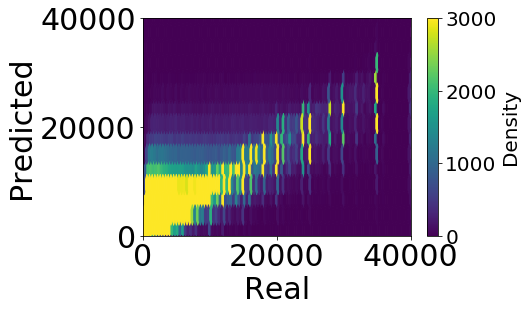

In [8]:
ax = plt.gca()

plt.hexbin(y_test, predicted, gridsize = 100, vmax = 3000)

plt.xlim(0, 40000)
plt.ylim(0, 40000)
ax.set_xlabel('Real', fontsize=30)
ax.set_ylabel('Predicted', fontsize=30)
ax.tick_params(axis='both', labelsize=30)
cax = plt.colorbar()
cax.ax.set_ylabel('Density',fontsize=20)
cax.ax.tick_params(labelsize=20)
plt.show()